In [1]:
%load_ext autoreload
%autoreload 2

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDataset, DAGMPatchDataset, DAGM_dataset_type, use_dagm_dev
from src.deep_ad.data.dagm_split import dagm_get_splits, dagm_patch_get_splits
from src.deep_ad.data.dagm_utils import dagm_get_class, dagm_get_image_name, dagm_get_patches_dir
from src.deep_ad.image import show_image_with_label, plot_images, surround_defect
from src.deep_ad.transforms import create_test_transform

In [2]:
# Load the configuration
config = Config(root_dir="..")

# DAGM 2007 Dataset

Display some random images from the dataset

In [6]:
dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, type="Defect-only")
limit = 5
while True:
    i = torch.randint(0, len(dagm_dataset), (1,)).item()
    image, label = dagm_dataset[i]
    title = f"Imaginea {i} - Clasa {dagm_get_class(dagm_dataset.image_paths[i])} - {dagm_get_image_name(dagm_dataset.image_paths[i])}.png"
    image = cv.cvtColor(image.squeeze().numpy(), cv.COLOR_BGR2RGB)
    label = cv.cvtColor(label.squeeze().numpy(), cv.COLOR_BGR2RGB)
    show_image_with_label(image, label, title)

    limit -= 1
    if limit == 0:
        break

### Dataset statistics

Number of images and labels

In [4]:
class_statistics_df = pd.DataFrame(
    columns=["Class", "Images", "Labels", "Defect-free images", "Percentage of images with defects"]
)
type: DAGM_dataset_type = "Original"

# Add class statistics
for cls in dagm_dataset.classes:
    class_dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, classes=[cls], type=type)
    class_total_images = len(class_dagm_dataset)
    class_total_labels = len(class_dagm_dataset.label_paths)
    class_statistics_df.loc[len(class_statistics_df)] = {
        "Class": cls,
        "Images": class_total_images,
        "Labels": class_total_labels,
        "Defect-free images": class_total_images - class_total_labels,
        "Percentage of images with defects": f"{100 * class_total_labels / class_total_images:.2f}%",
    }

# Add total statistics
dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, type=type)
total_images = len(dagm_dataset)
total_labels = len(dagm_dataset.label_paths)
class_statistics_df.loc["Total"] = {
    "Class": "Total",
    "Images": total_images,
    "Labels": total_labels,
    "Defect-free images": total_images - total_labels,
    "Percentage of images with defects": f"{100 * total_labels / total_images:.2f}%",
}

# Display statistics without the index column
display(class_statistics_df.style.hide())

Class,Images,Labels,Defect-free images,Percentage of images with defects
1,575,79,496,13.74%
2,575,66,509,11.48%
3,575,66,509,11.48%
4,575,82,493,14.26%
5,575,70,505,12.17%
6,575,83,492,14.43%
7,1150,150,1000,13.04%
8,1150,150,1000,13.04%
9,1150,150,1000,13.04%
10,1150,150,1000,13.04%


Statistics related to the sizes of defects expressed as numbers pixels

In [5]:
defects_statistics_df = pd.DataFrame(columns = ["Avg size", "Root avg", "Min size", "Root min", "Max size", "Root max"])
type: DAGM_dataset_type = "Original"
dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, type=type)

# Add statistics for each class
for cls in dagm_dataset.classes:
    class_dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, classes=[cls], type=type)
    label_paths = list(class_dagm_dataset.label_paths.values())
    labels = [cv.imread(path, cv.IMREAD_GRAYSCALE) for path in label_paths]
    defect_surfaces = np.array([label.sum() / 255 for label in labels])

    avg_size = f"{defect_surfaces.mean():.0f}"
    root_avg = f"{np.sqrt(defect_surfaces.mean()):.0f}"
    min_size = f"{defect_surfaces.min():.0f}"
    root_min = f"{np.sqrt(defect_surfaces.min()):.0f}"
    max_size = f"{defect_surfaces.max():.0f}"
    root_max = f"{np.sqrt(defect_surfaces.max()):.0f}"
    defects_statistics_df.loc[cls] = [avg_size, root_avg, min_size, root_min, max_size, root_max]
    
# Add statistics for whole dataset
label_paths = list(dagm_dataset.label_paths.values())
labels = [cv.imread(path, cv.IMREAD_GRAYSCALE) for path in label_paths]
defect_surfaces = np.array([label.sum() / 255 for label in labels])

avg_size = f"{defect_surfaces.mean():.0f}"
root_avg = f"{np.sqrt(defect_surfaces.mean()):.0f}"
min_size = f"{defect_surfaces.min():.0f}"
root_min = f"{np.sqrt(defect_surfaces.min()):.0f}"
max_size = f"{defect_surfaces.max():.0f}"
root_max = f"{np.sqrt(defect_surfaces.max()):.0f}"
defects_statistics_df.loc["Total"] = [avg_size, root_avg, min_size, root_min, max_size, root_max]

display(defects_statistics_df)

,Avg size,Root avg,Min size,Root min,Max size,Root max
1,9448,97,3886,62,22926,151
2,3030,55,645,25,16421,128
3,3558,60,1103,33,8571,93
4,7185,85,2260,48,13721,117
5,4826,69,1741,42,8961,95
6,21458,146,13820,118,24523,157
7,9683,98,3853,62,22443,150
8,1437,38,2,1,18743,137
9,972,31,736,27,1241,35
10,3484,59,959,31,12669,113


### Broken label

In [6]:
# TODO - fix this label as it contains only 2 pixels
print(label_paths[defect_surfaces.argmin()])
print(dagm_dataset.get_index_of_image(8, 1951))

C:\Stefan\Facultate\Licenta\Datasets\DAGM\Class8\Train\Label\1951_label.PNG
5400


In [7]:
image, label = dagm_dataset[5400]
image_np: np.ndarray = cv.cvtColor(image.numpy().squeeze(), cv.COLOR_GRAY2RGB)
label_np: np.ndarray = cv.cvtColor(label.numpy().squeeze(), cv.COLOR_GRAY2RGB)
print(f"label.shape = {label.shape}")
show_image_with_label(image_np, label_np, "Label")

label.shape = torch.Size([512, 512])


### Train, Val, Test datasets

In [12]:
# Use dev dataset so we can see the class of each image
train_dataset, val_dataset, test_dataset = dagm_get_splits(config, use_dagm_dev())

In [13]:
# Get classes of the images found in each dataset
train_classes = [cls for _, _, cls, _ in train_dataset]
val_classes = [cls for _, _, cls, _ in val_dataset]
test_classes = [cls for _, _, cls, _ in test_dataset]

We need to make sure that data across each class is split according to the same ratios (0.8, 0.1, 0.1).

We can also use this table to make sure the total number of images from each class matches the number of defect-free images.

In [14]:
df = pd.DataFrame(columns=["Class", "Train", "Val", "Test", "Total", "Train%", "Val%", "Test%"])
df["Class"] = DAGMDataset.all_classes
df["Train"] = [train_classes.count(str(cls)) for cls in DAGMDataset.all_classes]
df["Val"] = [val_classes.count(str(cls)) for cls in DAGMDataset.all_classes]
df["Test"] = [test_classes.count(str(cls)) for cls in DAGMDataset.all_classes]
df.loc[len(df)] = {
    "Class": "Total",
    "Train": df["Train"].sum(),
    "Val": df["Val"].sum(),
    "Test": df["Test"].sum(),
}

df["Total"] = df.apply(lambda row: row["Train"] + row["Val"] + row["Test"], axis=1)
df["Train%"] = df.apply(lambda row: f"{100 * row["Train"] / row["Total"]:.2f}%", axis=1)
df["Val%"] = df.apply(lambda row: f"{100 * row["Val"] / row["Total"]:.2f}%", axis=1)
df["Test%"] = df.apply(lambda row: f"{100 * row["Test"] / row["Total"]:.2f}%", axis=1)

display(df.style.hide())

Class,Train,Val,Test,Total,Train%,Val%,Test%
1,397,50,49,496,80.04%,10.08%,9.88%
2,408,51,50,509,80.16%,10.02%,9.82%
3,408,51,50,509,80.16%,10.02%,9.82%
4,395,49,49,493,80.12%,9.94%,9.94%
5,405,50,50,505,80.20%,9.90%,9.90%
6,394,49,49,492,80.08%,9.96%,9.96%
7,800,100,100,1000,80.00%,10.00%,10.00%
8,800,100,100,1000,80.00%,10.00%,10.00%
9,800,100,100,1000,80.00%,10.00%,10.00%
10,800,100,100,1000,80.00%,10.00%,10.00%


### Cum arată imaginile

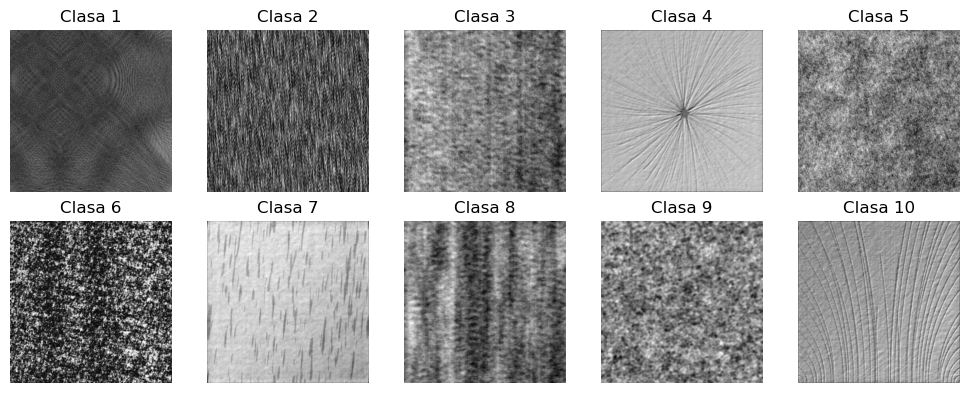

In [28]:
%matplotlib inline

classes = list(range(1, 11))
images = []
titles = []
for cls in classes:
    dagm_dataset = DAGMDataset(
        img_dir=config.DAGM_raw_dir, classes=[cls], type="Defect-free", transform=create_test_transform()
    )
    image, key = dagm_dataset[0]
    images.append(image.squeeze())
    titles.append(f"Clasa {cls}")

plot_images(images, titles, rows=2, cols=5, figsize=(10, 4), show=False)
plt.savefig("defect_free_images.pdf")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

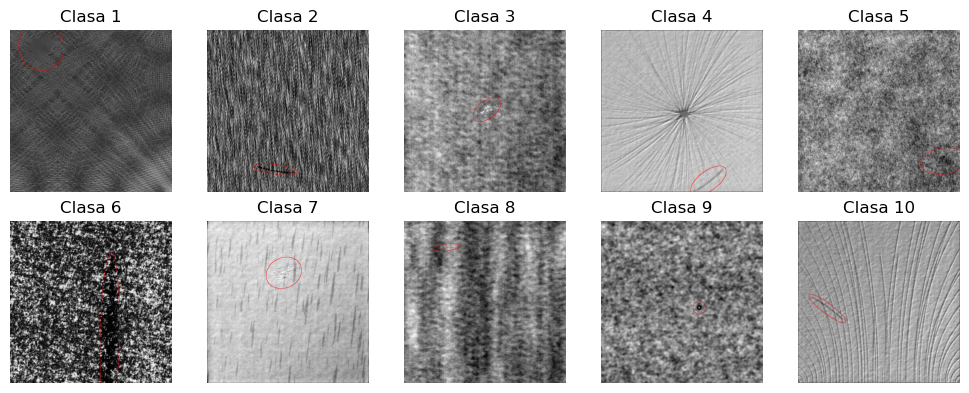

In [43]:
%matplotlib inline

classes = list(range(1, 11))
images = []
titles = []
for cls in classes:
    dagm_dataset = DAGMDataset(
        img_dir=config.DAGM_raw_dir, classes=[cls], type="Defect-only", transform=create_test_transform()
    )
    image, key = dagm_dataset[0]
    images.append(surround_defect(image.permute((1, 2, 0)).numpy(), key.numpy()))
    titles.append(f"Clasa {cls}")

plot_images(images, titles, rows=2, cols=5, figsize=(10, 4), show=False)
plt.savefig("defect_only_images.pdf")

## Patches Dataset

Number of patches per class

In [3]:
class_statistics_df = pd.DataFrame(columns=["Class", "Patches", "Patches / PPI", "Defect-free images"])
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size)

# Add class statistics
for cls in DAGMDataset.all_classes:
    class_dagm_patch_dataset = DAGMPatchDataset(img_dir=patches_dir, classes=[cls])
    class_dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, classes=[cls], type="Defect-free")
    class_statistics_df.loc[len(class_statistics_df)] = {
        "Class": cls,
        "Patches": len(class_dagm_patch_dataset),
        "Defect-free images": len(class_dagm_dataset),
    }

# Add total statistics
dagm_patch_dataset = DAGMPatchDataset(img_dir=patches_dir)
dagm_dataset = DAGMDataset(img_dir=config.DAGM_raw_dir, type="Defect-free")
class_statistics_df.loc["Total"] = {
    "Class": "Total",
    "Patches": len(dagm_patch_dataset),
    "Defect-free images": len(dagm_dataset),
}

# Add Patches / PPI column
class_statistics_df["Patches / PPI"] = class_statistics_df.apply(
    lambda row: f"{row['Patches'] / config.ppi:.0f}", axis=1
)

# Display statistics without the index column
display(class_statistics_df.style.hide())

Class,Patches,Patches / PPI,Defect-free images
1,1984,496,496
2,2036,509,509
3,2036,509,509
4,1972,493,493
5,2020,505,505
6,1968,492,492
7,4000,1000,1000
8,4000,1000,1000
9,4000,1000,1000
10,4000,1000,1000


### Train, Val, Test datasets

In [22]:
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config)
train_classes, val_classes, test_classes = (
    train_dataset.patch_classes,
    val_dataset.patch_classes,
    test_dataset.patch_classes,
)

We need to make sure that data across each class is split according to the same ratios (0.8, 0.1, 0.1).

In [23]:
df = pd.DataFrame(columns=["Class", "Train", "Val", "Test", "Total", "Train%", "Val%", "Test%"])
df["Class"] = DAGMDataset.all_classes
df["Train"] = [train_classes.count(cls) for cls in DAGMDataset.all_classes]
df["Val"] = [val_classes.count(cls) for cls in DAGMDataset.all_classes]
df["Test"] = [test_classes.count(cls) for cls in DAGMDataset.all_classes]
df.loc[len(df)] = {
    "Class": "Total",
    "Train": df["Train"].sum(),
    "Val": df["Val"].sum(),
    "Test": df["Test"].sum(),
}

df["Total"] = df.apply(lambda row: row["Train"] + row["Val"] + row["Test"], axis=1)
df["Train%"] = df.apply(lambda row: f"{100 * row["Train"] / row["Total"]:.2f}%", axis=1)
df["Val%"] = df.apply(lambda row: f"{100 * row["Val"] / row["Total"]:.2f}%", axis=1)
df["Test%"] = df.apply(lambda row: f"{100 * row["Test"] / row["Total"]:.2f}%", axis=1)

display(df.style.hide())

Class,Train,Val,Test,Total,Train%,Val%,Test%
1,1587,198,199,1984,79.99%,9.98%,10.03%
2,1629,203,204,2036,80.01%,9.97%,10.02%
3,1629,203,204,2036,80.01%,9.97%,10.02%
4,1577,198,197,1972,79.97%,10.04%,9.99%
5,1616,202,202,2020,80.00%,10.00%,10.00%
6,1574,197,197,1968,79.98%,10.01%,10.01%
7,3200,400,400,4000,80.00%,10.00%,10.00%
8,3200,400,400,4000,80.00%,10.00%,10.00%
9,3200,400,400,4000,80.00%,10.00%,10.00%
10,3200,400,400,4000,80.00%,10.00%,10.00%
